### Hooty
#### Your personal safety buddy
The aim of the personal protection buddy is to tell the user if they're in a safe place and what kind of crimes they should be on the lookout for and where to visit or chill.

User will enter where they want to visit in SA, or where a club is and the app will tell them what the stats are.

- Use jupyter notebook for the coding
- Use GitHub to store
- Use Streamlit for the app
- Use Comet to run experiments

Consider looking at percentage increases across cities in a province.
Strandfontein rape vs Muizenberg rape (percentage increase)

Free app vs Paid app
compare two places vs compare a number of places

User Tkinter to make GUI, see https://datatofish.com/multiple-linear-regression-python/

Display mapping using python and GIS / python mapping

Data will be limited to contact crimes. Contact crimes refers to those crimes in which the victims themselves are the targets of violence or property is targeted and the victims in the vicinity during the commission of the crime are subjected to threats of violence or the use of such violence. These include:
* Murder
* Sexual Offences (i.e. Rape, attempted sexual offences, contact sexual offences and sexual assault)
* Attempted Murder
* Assault GBH
* Common Assault
* Common Robbery
* Robbery aggravating

I will only focus on contact crimes reported by the community and not those detected by police action.

# Importing packages

In [1]:
import pandas as pd
import numpy as np
import copy
from geopandas.tools import geocode 

from urllib.request import urlopen
from bs4 import BeautifulSoup
import mechanicalsoup
import re

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')


# Importing data

In [7]:
# # Upload station data
# !gdown --id 1fbzEM9_WRuVwUALMJ255bJKfkL43z0dc 

# # create the dataframe
# station_stats_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Hooty/station data.csv')

station_stats_df = pd.read_csv('station data.csv')

Next I will create a deepcopy of the original dataframe to avoid making inadvertent changes to the dataframe.

In [8]:
# create deep copy of the imdb dataframe
station_stats_dfC = pd.DataFrame(columns = station_stats_df.columns, data = copy.deepcopy(station_stats_df.values))

## Data description

Next we will describe the dataset.

# Exploratory Data Analysis

In [9]:
# print the first five rows
station_stats_dfC.head()

,Unnamed: 0,Crime Category station Province_station,Crime Category prov,Crime Category station,station,Station_type,Province_station,cluster,prov,Crime Category,...,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021
0,NaN,17 Community Reported Serious Crime EASTERN CA...,17 Community Reported Serious Crime EC,17 Community Reported Serious Crime EASTERN CAPE,EASTERN CAPE,0,EASTERN_CAPE,EC,EC,17 Community Reported Serious Crime,...,188898.0,182634.0,180732.0,172562.0,166077.0,167892.0,163189.0,169300.0,168322.0,146280.0
1,NaN,All theft not mentioned elsewhere EASTERN CAPE...,All theft not mentioned elsewhere EC,All theft not mentioned elsewhere EASTERN CAPE,EASTERN CAPE,0,EASTERN_CAPE,EC,EC,All theft not mentioned elsewhere,...,28931.0,26198.0,27699.0,25597.0,23429.0,24486.0,23174.0,24277.0,24188.0,21068.0
2,NaN,Arson EASTERN CAPE EASTERN_CAPE,Arson EC,Arson EASTERN CAPE,EASTERN CAPE,0,EASTERN_CAPE,EC,EC,Arson,...,980.0,968.0,1061.0,785.0,679.0,748.0,605.0,698.0,666.0,560.0
3,NaN,Assault with the intent to inflict grievous bo...,Assault with the intent to inflict grievous bo...,Assault with the intent to inflict grievous bo...,EASTERN CAPE,0,EASTERN_CAPE,EC,EC,Assault with the intent to inflict grievous bo...,...,29275.0,27788.0,27361.0,25431.0,24818.0,23241.0,23133.0,24125.0,23376.0,20238.0
4,NaN,Attempted murder EASTERN CAPE EASTERN_CAPE,Attempted murder EC,Attempted murder EASTERN CAPE,EASTERN CAPE,0,EASTERN_CAPE,EC,EC,Attempted murder,...,1721.0,1755.0,1853.0,1832.0,2052.0,2110.0,2232.0,2305.0,2409.0,2104.0


From the table above, it appears:
* `Crime Category station Province_station` is a concatenation of the `Crime Category`, `station` and `Province_station` features. 
* `Crime Category prov` is a concatenation of the `Crime`, `Category` and `prov` features.
* `Crime Category station` is a concatenation of the `Crime`, `Category` and `station` features.

These redundancies will be removed.

In [10]:
# print the column names
print('There are', len(station_stats_dfC.columns), 'columns in the dataset. These are:\n')
station_stats_dfC.info()

There are 23 columns in the dataset. These are:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45605 entries, 0 to 45604
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Unnamed: 0                               0 non-null      object
 1   Crime Category station Province_station  45603 non-null  object
 2   Crime Category prov                      45603 non-null  object
 3   Crime Category station                   45603 non-null  object
 4   station                                  45603 non-null  object
 5   Station_type                             45603 non-null  object
 6   Province_station                         45603 non-null  object
 7   cluster                                  45564 non-null  object
 8   prov                                     45603 non-null  object
 9   Crime Category                           45603 non-null  object
 10  2008-2009

The following features are of type object;
`2011-2012`, `2012-2013`, `2013-2014`,	`2014-2015`	`2015-2016`,	`2016-2017`,	`2017-2018`,	`2018-2019`	`2019-2020`,	`2020-2021`. The will all be converted to type integer as they represent numeric counts. 

There are two rows of null values. These appears consistent across the dataset and will therefor be removed.

In [11]:
# identify the NaN rows
station_stats_dfC[station_stats_dfC['Province_station'].isnull()]

,Unnamed: 0,Crime Category station Province_station,Crime Category prov,Crime Category station,station,Station_type,Province_station,cluster,prov,Crime Category,...,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021
45564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# delete the NaN value rows based on their index numbers
station_stats_dfC.drop([45564,45565], axis=0, inplace=True)

#### Inconsistent data
Next I will identify the inconsistencies in categorical data. 
First I will identify potential categories within the features. 

In [13]:
# calculate the number of unique values per features
station_stats_dfC.nunique()

Unnamed: 0                                     0
Crime Category station Province_station    45603
Crime Category prov                          404
Crime Category station                     45603
station                                     1168
Station_type                                1159
Province_station                              10
cluster                                       85
prov                                          10
Crime Category                                47
2008-2009                                   2198
2009-2010                                   2183
2010-2011                                   2169
2011-2012                                   2172
2012-2013                                   2183
2013-2014                                   2222
2014-2015                                   2207
2015-2016                                   2188
2016-2017                                   2204
2017-2018                                   2173
2018-2019           

From the information above it appears that the following features may contain categorical data:
* `Province_station`, with 10 unique entries.
* `cluster`, with 85 unique entries. 
* `prov`, with 10 unique entries.
* `Crime Category`, with 47 unique entries.

Next I will look into each of these features, starting with Province_station, to get a better understanding of the data.

In [14]:
# identify the unique Province_station values
print('These are the unique Province_station values:\n')
for i in list(station_stats_dfC.Province_station.unique()):
  print('--',i)

These are the unique Province_station values:

-- EASTERN_CAPE
-- FREE_STATE
-- GAUTENG
-- KWAZULU_NATAL
-- LIMPOPO
-- MPUMALANGA
-- NORTH_WEST
-- NORTHERN_CAPE
-- RSA
-- WESTERN_CAPE


* The `Province_station` feature contains Provincial names.
* There is a redundent `Unnamed: 0` column with all null entries. while the `Crime Category station Province_station`,	`Crime Category prov` and `Crime Category station` appears to be aggregations of information found in a number of other features such as `Crime Category`, `Province_station` and `station`. I will remove these columns.

In [15]:
# identify the unique cluster values
print('These are the first 5 out of 85 unique cluster values:\n')
for i in list(station_stats_dfC.cluster.unique())[:5]:
  print('--',i)

These are the first 5 out of 85 unique cluster values:

-- EC
-- GRAAFF-REINET CC
-- UITENHAGE CC
-- CRADOCK CC
-- MOUNT FLETCHER CC


The `cluster` feautes does not appear to be categorical values but rather city / town identifiers except for instances where the abbreviated Provincial names are used. These rows coincide with the totals. Therefor these rows aggregate the data on a provincial level.

Next I will look into the `prov` feature.

In [16]:
# identify the unique prov values
print('These are the unique prov values:\n')
for i in list(station_stats_dfC.prov.unique()):
  print('--',i)

These are the unique prov values:

-- EC
-- FS
-- GP
-- KZN
-- LP
-- MP
-- NW
-- NC
-- RSA
-- WC


The `prov` feature appears to hold abbreviations of the provinces listed in the `Province_station` feature. If so, it will be dropped as it's redundant. Let's group the data by `Province_station` and `prov` to confirm.

In [17]:
# group the dataframe
station_stats_dfC.groupby(['Province_station','prov']).size()

Province_station  prov
EASTERN_CAPE      EC      7767
FREE_STATE        FS      4373
GAUTENG           GP      5656
KWAZULU_NATAL     KZN     7293
LIMPOPO           LP      4095
MPUMALANGA        MP      3549
NORTHERN_CAPE     NC      3588
NORTH_WEST        NW      3276
RSA               RSA       39
WESTERN_CAPE      WC      5967
dtype: int64

The table above confirms that the `prov` feature is abbreviatied `Province_station` data. Therefor `prov` will be dropped to reduce dimensionality.

Next I will look into the `Crime Category` data. 

In [18]:
# identify the unique Crime Category values
print('These are the 47 unique Crime Category values:\n')
for i in list(station_stats_dfC['Crime Category'].unique()):
  print('--',i)

These are the 47 unique Crime Category values:

-- 17 Community Reported Serious Crime
-- All theft not mentioned elsewhere
-- Arson
-- Assault with the intent to inflict grievous bodily harm
-- Attempted murder
-- Attempted sexual offences
-- Bank Robbery
-- Burglary at non-residential premises
-- Burglary at residential premises
-- Carjacking
-- Commercial Crime
-- Common assault
-- Common robbery
-- Contact Crime
-- Contact sexual offences
-- Contact-related crime
-- Crime detected as a result of police action
-- Driving under the influence of alcohol or drugs
-- Drug-related Crime
-- Illegal possession of firearms and ammunition
-- Kidnapping
-- Malicious damage to property
-- Murder
-- Other serious crime
-- Property-related crime
-- Rape
-- Robbery at non-residential premises
-- Robbery at residential premises
-- Robbery of cash in transit
-- Robbery with aggravating circumstances
-- Sexual Assault
-- Sexual Offences
-- Sexual offences detected as a result of police action
-- Sho

## Remove redundant features
Next we will remove the previously identified redundancies.

In [19]:
# list redundant features
redundant_cols = ['Unnamed: 0','Crime Category station Province_station', 
                  'Crime Category prov', 'Crime Category station']

# drop the redundant
station_stats_dfC.drop(redundant_cols, axis=1, inplace=True)


Next we will extract only contact crime related data.

The data also contains provincial totals per crime category. These will be removed as adding them to the individual rows will exaggerate the amounts.

In [83]:
# list of all contact related crimes
contact_crime = ['Assault with the intent to inflict grievous bodily harm',
                 'Attempted murder', 'Attempted sexual offences', 'Common assault',
                 'Common robbery', 'Robbery with aggravating circumstances',
                 'Contact sexual offences' , 'Murder', 'Rape', 'Sexual Assault', 'Sexual Offences']

# extract contact related crimes
contact_crime_df = station_stats_dfC[station_stats_dfC['Crime Category'].isin(contact_crime)]

# remove the row totals
query = (contact_crime_df['Station_type'] != '0') | ((contact_crime_df['station'] == 'LAERSDRIFT') 
                                                     & (contact_crime_df['Station_type'] == '0'))
# apply the query
contact_crime_df = contact_crime_df[query]

Next we will replace the spaces between text in the crime category column to aid analysis. We will also abbreviated the following crime category names:
* Assault with the intent to inflict grievous bodily harm -> Assault_GBH
* Robbery with aggravating circumstances -> Robbery_AC

In [84]:
# replace the space with _ for crime categories
contact_crime_df['Crime Category'] = contact_crime_df['Crime Category'].str.replace(' ','_')

# shorted 'Assault with the intent to inflict grievous bodily harm'
contact_crime_df['Crime Category'] = contact_crime_df['Crime Category'].str.replace(
    'Assault_with_the_intent_to_inflict_grievous_bodily_harm','Assault_GBH')

# shorted 'Robbery with aggravating circumstances'
contact_crime_df['Crime Category'] = contact_crime_df['Crime Category'].str.replace(
    'Robbery_with_aggravating_circumstances','Robbery_with_AC')

contact_crime_df.head()

,station,Station_type,Province_station,cluster,prov,Crime Category,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021
41,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Assault_GBH,69.0,67.0,53.0,62.0,57.0,54.0,78.0,87.0,61.0,58.0,54.0,60.0,48.0
42,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Attempted_murder,0.0,3.0,0.0,0.0,1.0,1.0,2.0,5.0,2.0,1.0,2.0,4.0,2.0
43,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Attempted_sexual_offences,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0
49,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Common_assault,32.0,31.0,24.0,19.0,20.0,21.0,23.0,48.0,24.0,24.0,32.0,28.0,34.0
50,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Common_robbery,3.0,2.0,5.0,1.0,0.0,0.0,6.0,10.0,10.0,6.0,7.0,1.0,7.0


In [85]:
contact_crime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12749 entries, 41 to 45597
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   station           12749 non-null  object
 1   Station_type      12749 non-null  object
 2   Province_station  12749 non-null  object
 3   cluster           12738 non-null  object
 4   prov              12749 non-null  object
 5   Crime Category    12749 non-null  object
 6   2008-2009         12749 non-null  object
 7   2009-2010         12749 non-null  object
 8   2010-2011         12749 non-null  object
 9   2011-2012         12749 non-null  object
 10  2012-2013         12749 non-null  object
 11  2013-2014         12749 non-null  object
 12  2014-2015         12749 non-null  object
 13  2015-2016         12749 non-null  object
 14  2016-2017         12749 non-null  object
 15  2017-2018         12749 non-null  object
 16  2018-2019         12749 non-null  object
 17  2019-2020  

## EDA - Distribution by Crime Category

In [86]:
# the listed column years
list_of_years = ['2008-2009','2009-2010', '2010-2011','2011-2012','2012-2013','2013-2014','2014-2015',
                 '2015-2016','2016-2017','2017-2018','2018-2019','2019-2020','2020-2021']

# group the data by crime category
grouped_by_category = contact_crime_df.groupby('Crime Category')[list_of_years].sum()
grouped_by_category = grouped_by_category.reset_index()
grouped_by_category

,Crime Category,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021
0,Assault_GBH,202328.0,203807.0,197470.0,191612.0,185050.0,182333.0,182556.0,182933.0,170616.0,167352.0,170979.0,166720.0,143393.0
1,Attempted_murder,18140.0,17247.0,15360.0,14730.0,16236.0,16989.0,17537.0,18127.0,18205.0,18233.0,18980.0,18635.0,18707.0
2,Attempted_sexual_offences,3808.0,3811.0,3599.0,3535.0,3293.0,2913.0,2641.0,2573.0,2073.0,2066.0,2146.0,2076.0,1800.0
3,Common_assault,190709.0,194922.0,184103.0,180165.0,171653.0,166081.0,161486.0,164958.0,156450.0,156243.0,162012.0,165494.0,149442.0
4,Common_robbery,58764.0,56993.0,54442.0,52566.0,53196.0,53505.0,54927.0,54110.0,53418.0,50730.0,51765.0,51825.0,37648.0
5,Contact_sexual_offences,12346.0,8293.0,6158.0,2741.0,2220.0,1821.0,1694.0,1607.0,1488.0,1221.0,1254.0,1179.0,1059.0
6,Murder,18084.0,16767.0,15893.0,15554.0,16213.0,17023.0,17805.0,18673.0,19016.0,20336.0,21022.0,21325.0,19972.0
7,Rape,46647.0,48259.0,48158.0,47069.0,48408.0,45349.0,43195.0,41503.0,39828.0,40035.0,41583.0,42291.0,36330.0
8,Robbery_with_AC,120920.0,113200.0,101039.0,100769.0,105488.0,118963.0,129045.0,132527.0,140956.0,138364.0,140032.0,143990.0,119841.0
9,Sexual_Assault,6396.0,6629.0,7006.0,7194.0,6967.0,6597.0,6087.0,6212.0,6271.0,6786.0,7437.0,7749.0,7025.0


In [87]:
grouped_by_category_Pivot = grouped_by_category.pivot_table(columns='Crime Category')
grouped_by_category_Pivot = grouped_by_category_Pivot.reset_index()

In [88]:
# export the grouped_by_category_Pivot
grouped_by_category_Pivot.to_csv('grouped_by_category_Pivot.csv', index = False)

Next I will create box and whisker plots for each crime category across the years to get an understanding of the distribution and movement of the number of cases per category.

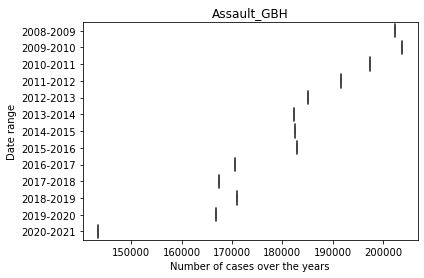

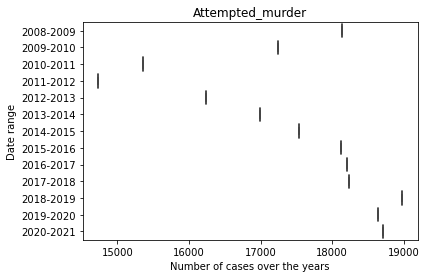

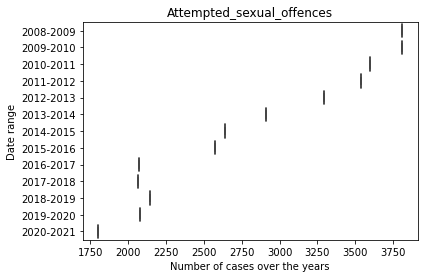

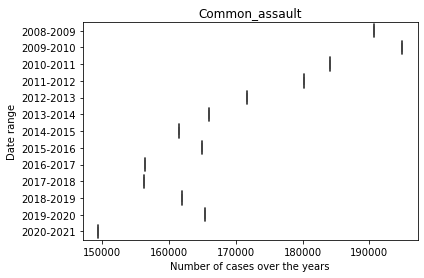

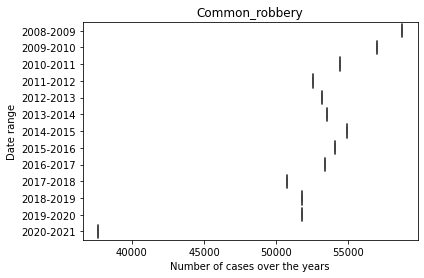

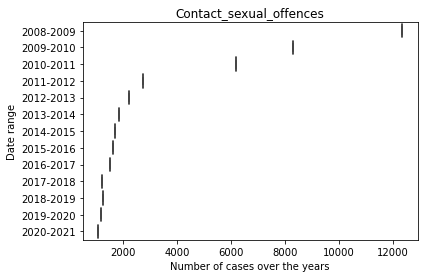

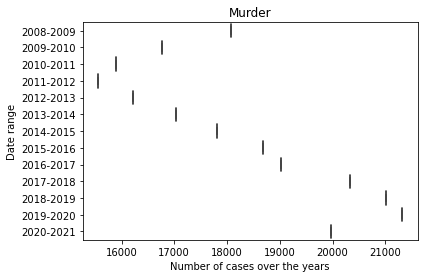

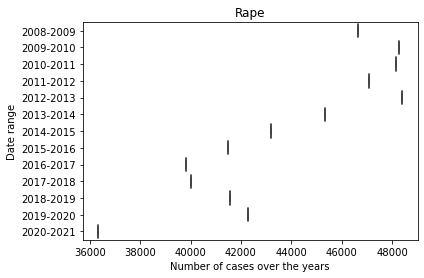

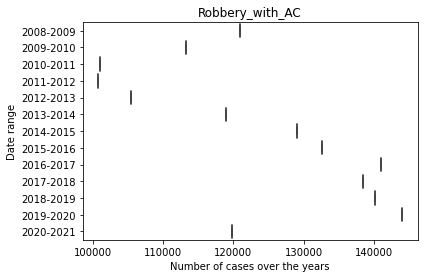

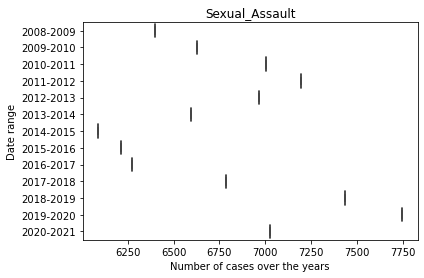

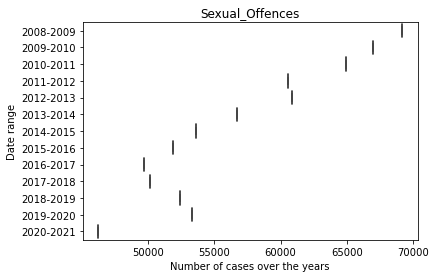

In [89]:
fig, ax = plt.subplots()

# Compute whisker plot for each crime category
for crime in list(contact_crime_df['Crime Category'].unique()):
    _ = sns.boxplot(x=crime, y='index', data = grouped_by_category_Pivot)

    # plot labels and title
    _ = plt.title(crime)
    _ = plt.xlabel('Number of cases over the years')
    _ = plt.ylabel('Date range')

    # display the plot
    plt.show()
    plt.close()

Next we will get a visual understanding of the contact crime distribution per category.

In [90]:
# group the data by crime category and province
grouped_by_province = contact_crime_df.groupby(['Crime Category', 'Province_station'])[list_of_years].sum()

# reset the index and extrapolate the index into column
grouped_by_province = grouped_by_province.reset_index()
grouped_by_province

,Crime Category,Province_station,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021
0,Assault_GBH,EASTERN_CAPE,31234.0,32081.0,30671.0,29275.0,27788.0,27361.0,25431.0,24818.0,23241.0,23133.0,24125.0,23376.0,20238.0
1,Assault_GBH,FREE_STATE,15756.0,15609.0,15333.0,14955.0,15317.0,14465.0,13458.0,13116.0,11702.0,10842.0,11120.0,10887.0,9550.0
2,Assault_GBH,GAUTENG,47604.0,48373.0,46072.0,42939.0,40430.0,41182.0,41830.0,42790.0,39684.0,39552.0,39805.0,38362.0,33605.0
3,Assault_GBH,KWAZULU_NATAL,29958.0,30723.0,30491.0,29504.0,28832.0,28982.0,29201.0,28665.0,26824.0,26693.0,26878.0,27418.0,23531.0
4,Assault_GBH,LIMPOPO,13138.0,13259.0,12869.0,14663.0,13710.0,12645.0,13511.0,14143.0,12948.0,12005.0,12116.0,11368.0,9976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Sexual_Offences,LIMPOPO,4566.0,4807.0,4799.0,4836.0,4866.0,4423.0,4312.0,4369.0,3828.0,3862.0,4060.0,3990.0,3720.0
95,Sexual_Offences,MPUMALANGA,4634.0,4516.0,4345.0,3955.0,4065.0,3797.0,3474.0,3331.0,3216.0,3198.0,3470.0,3513.0,3134.0
96,Sexual_Offences,NORTHERN_CAPE,1904.0,1829.0,1857.0,1722.0,1826.0,1731.0,1578.0,1719.0,1587.0,1538.0,1578.0,1590.0,1295.0
97,Sexual_Offences,NORTH_WEST,4962.0,4695.0,4649.0,4885.0,5228.0,4616.0,4585.0,4164.0,4326.0,4182.0,4021.0,3826.0,3262.0


In [91]:
# export grouped_by_province
grouped_by_province.to_csv('grouped_by_province.csv', index = False)

Next we will get a visual understanding of the contact crime distribution per province for all contact crimes, for the year 2020-2021.

LET IT SWARM FOR ALL YEARS

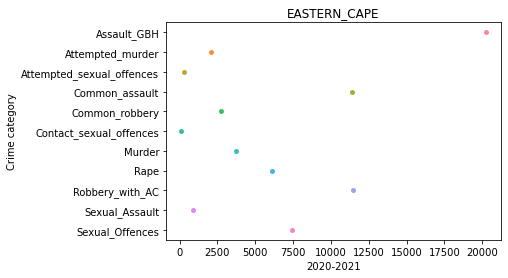

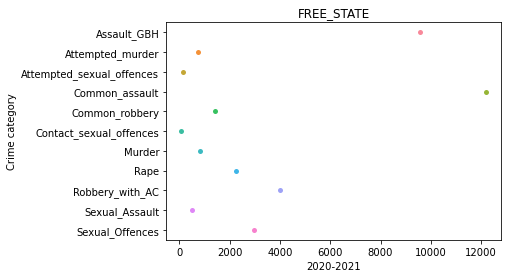

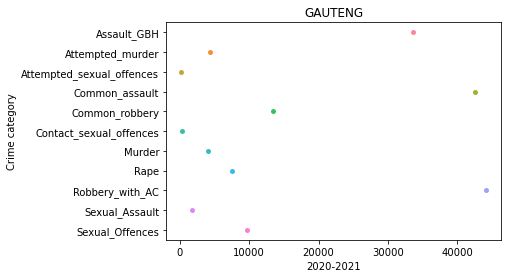

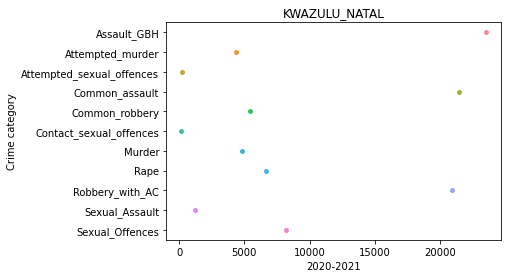

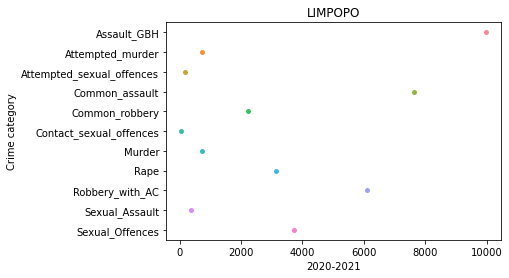

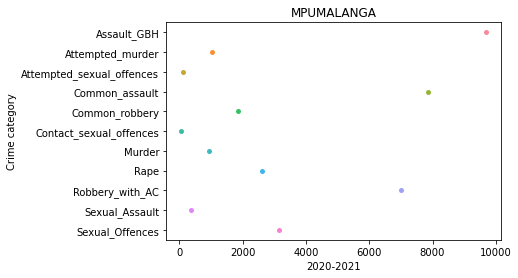

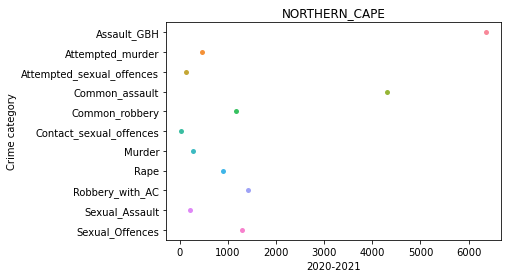

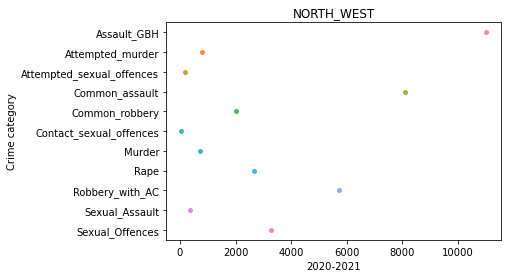

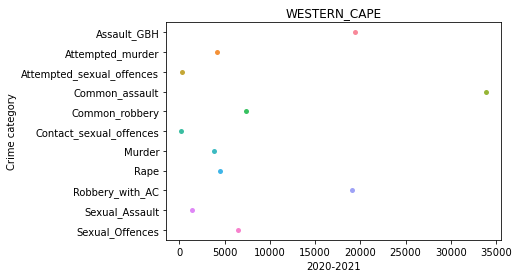

In [92]:
p_list = list(grouped_by_province['Province_station'].unique())

fig, ax = plt.subplots()

# Loop over the different sports branches
for province in p_list:
    # Extract the rows only for this sport
    df = grouped_by_province[grouped_by_province['Province_station'] == province]
  
    # Add a bar for the "Weight" mean with std y error bar
    sns.swarmplot(x='2020-2021', y= grouped_by_province['Crime Category'], data = df)

    _ = plt.title(province)
    _ = plt.ylabel('Crime category')
    plt.show()
    plt.close()

Next we will get a visual understanding of the contact crime distribution per crime over all provinces for the year 2020-2021.

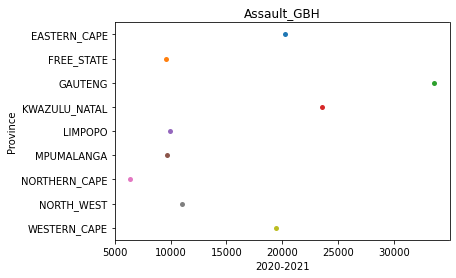

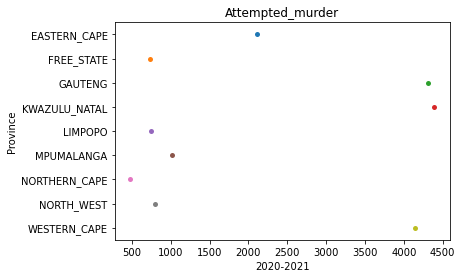

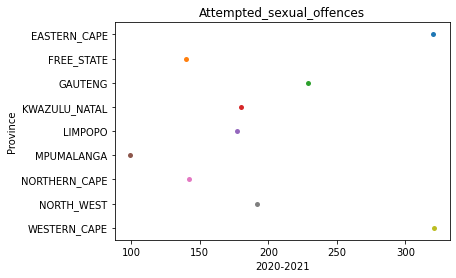

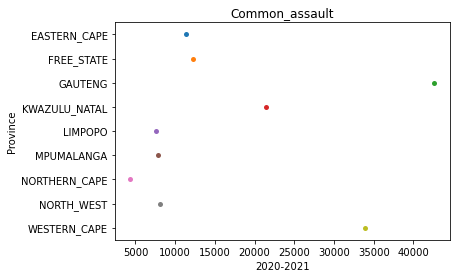

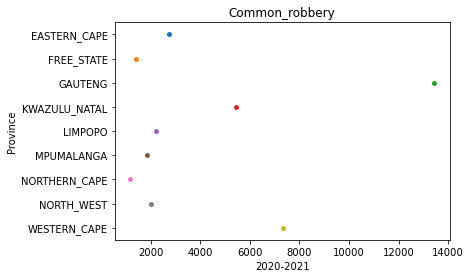

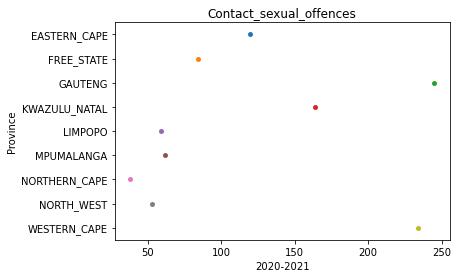

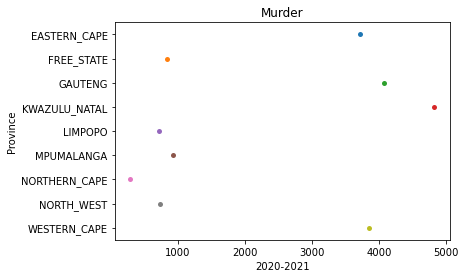

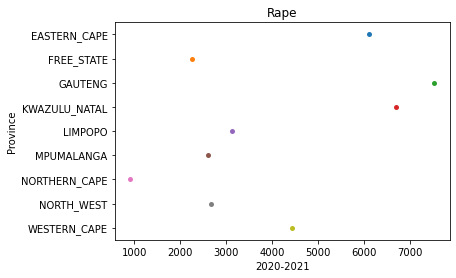

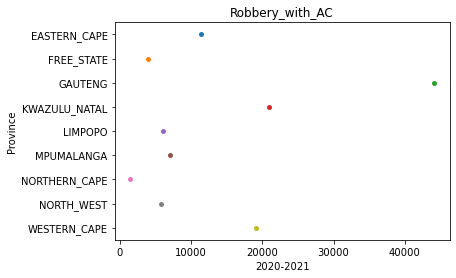

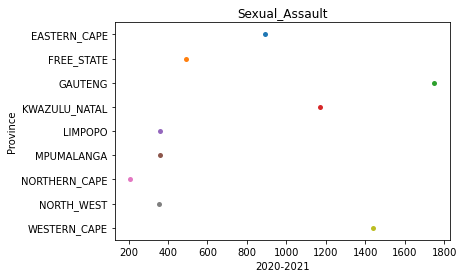

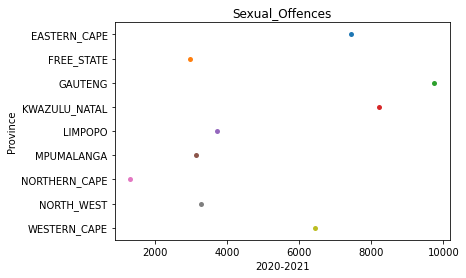

In [93]:
# p_list = list(grouped_by_province['Province_station'].unique())
c_list = list(grouped_by_province['Crime Category'].unique())

fig, ax = plt.subplots()

# Loop over the different sports branches
for crime in c_list:
    # Extract the rows only for this sport
    df = grouped_by_province[grouped_by_province['Crime Category'] == crime]
  
    # Add a bar for the "Weight" mean with std y error bar
    sns.swarmplot(x='2020-2021', y= grouped_by_province['Province_station'], data = df)

    _ = plt.title(crime)
    _ = plt.ylabel('Province')
    plt.show()
    plt.close()

## EDA - Distribution by Province

Next we will get a visual understanding of the contact crime distribution per province.

In [94]:
grouped_by_province

,Crime Category,Province_station,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021
0,Assault_GBH,EASTERN_CAPE,31234.0,32081.0,30671.0,29275.0,27788.0,27361.0,25431.0,24818.0,23241.0,23133.0,24125.0,23376.0,20238.0
1,Assault_GBH,FREE_STATE,15756.0,15609.0,15333.0,14955.0,15317.0,14465.0,13458.0,13116.0,11702.0,10842.0,11120.0,10887.0,9550.0
2,Assault_GBH,GAUTENG,47604.0,48373.0,46072.0,42939.0,40430.0,41182.0,41830.0,42790.0,39684.0,39552.0,39805.0,38362.0,33605.0
3,Assault_GBH,KWAZULU_NATAL,29958.0,30723.0,30491.0,29504.0,28832.0,28982.0,29201.0,28665.0,26824.0,26693.0,26878.0,27418.0,23531.0
4,Assault_GBH,LIMPOPO,13138.0,13259.0,12869.0,14663.0,13710.0,12645.0,13511.0,14143.0,12948.0,12005.0,12116.0,11368.0,9976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Sexual_Offences,LIMPOPO,4566.0,4807.0,4799.0,4836.0,4866.0,4423.0,4312.0,4369.0,3828.0,3862.0,4060.0,3990.0,3720.0
95,Sexual_Offences,MPUMALANGA,4634.0,4516.0,4345.0,3955.0,4065.0,3797.0,3474.0,3331.0,3216.0,3198.0,3470.0,3513.0,3134.0
96,Sexual_Offences,NORTHERN_CAPE,1904.0,1829.0,1857.0,1722.0,1826.0,1731.0,1578.0,1719.0,1587.0,1538.0,1578.0,1590.0,1295.0
97,Sexual_Offences,NORTH_WEST,4962.0,4695.0,4649.0,4885.0,5228.0,4616.0,4585.0,4164.0,4326.0,4182.0,4021.0,3826.0,3262.0


### ECDF plotting
Next we will graphically display the distribution of cases per crime over all provinces using an ECDF (Estimator of the Cumulative Distribution Function) plot. ECDF represents the proportion or count of observations falling below each unique value in a dataset. Compared to a histogram or density plot, it has the advantage that each observation is visualized directly, meaning that there are no binning or smoothing parameters that need to be adjusted.

In [95]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n
    return x, y


def filter_df(func):
    """Return a filtered dataframe"""
    def wrapper(crime):
        # subset the dataframe based on the crime
        df = grouped_by_province[grouped_by_province['Crime Category'] == crime]        
        return func(df)
    return wrapper


def create_series(func):
    """Return a dictionary of each province's crime stats as a series"""
    def wrapper(df):
        # create empty series objects for each province
        EASTERN_CAPE = pd.Series() 
        FREE_STATE = pd.Series() 
        GAUTENG = pd.Series() 
        KWAZULU_NATAL = pd.Series() 
        LIMPOPO = pd.Series() 
        MPUMALANGA = pd.Series() 
        NORTH_WEST = pd.Series() 
        NORTHERN_CAPE = pd.Series() 
        WESTERN_CAPE = pd.Series() 

        # dictionary of provincial series
        prov_series_dict = {'EASTERN_CAPE':EASTERN_CAPE, 'FREE_STATE':FREE_STATE, 
                            'GAUTENG': GAUTENG, 'KWAZULU_NATAL':KWAZULU_NATAL,
                           'LIMPOPO':LIMPOPO, 'MPUMALANGA':MPUMALANGA, 'NORTH_WEST':NORTH_WEST,
                           'NORTHERN_CAPE': NORTHERN_CAPE, 'WESTERN_CAPE':WESTERN_CAPE }

        # fill the empty provincial series with data
        for p in list(df['Province_station'].unique()):
            q = (df['Province_station'] == p)
            # create 1 dimensional series
            prov_series_dict[p] = df[q][list_of_years].squeeze()        
            
        # function being wrapped
        return func(prov_series_dict)
    return wrapper


@filter_df        
@create_series       
def generate_ECDF(prov_series_dict):
    """ Generates the ECDF plots"""  
    
    fig, ax = plt.subplots()
    
    # Compute ECDF for the crime for each province
    for k,v in prov_series_dict.items():
        x, y = ecdf(v)
        _ = plt.plot(x, y, marker='.', linestyle='none')

    # plot labels and title
    _ = plt.title(title)
    _ = plt.xlabel('Number of cases over the years')
    _ = plt.ylabel('ECDF')

    # plot legend
    plt.legend(prov_series_dict.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    # display the plot
    plt.show()


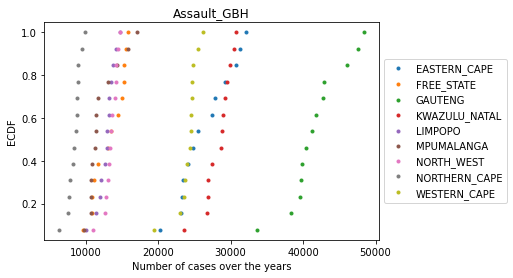

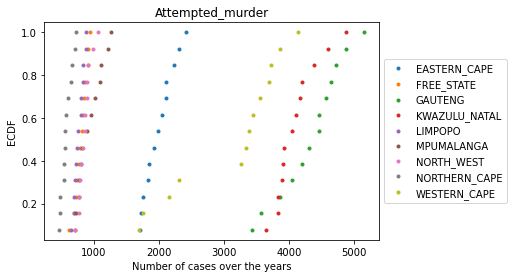

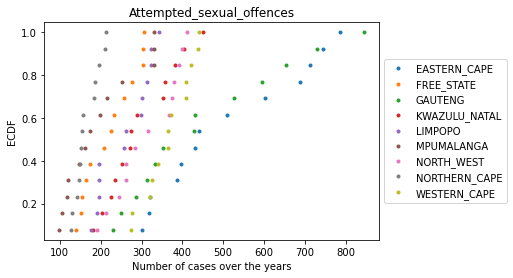

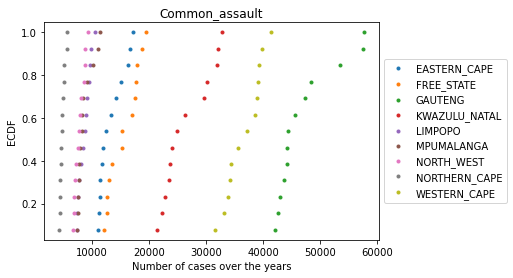

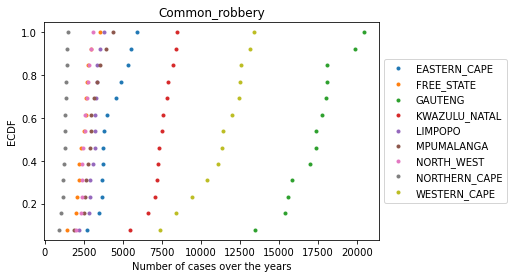

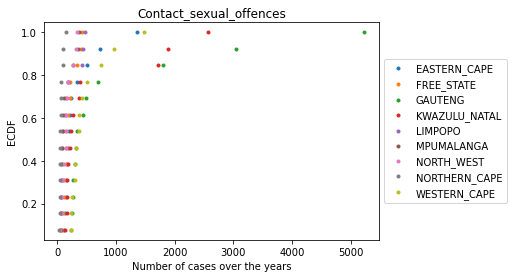

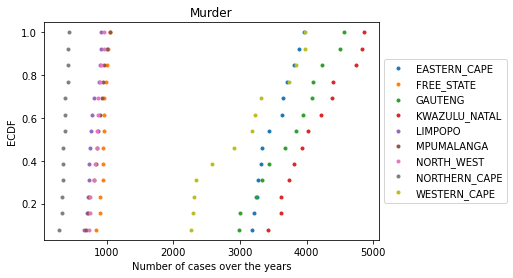

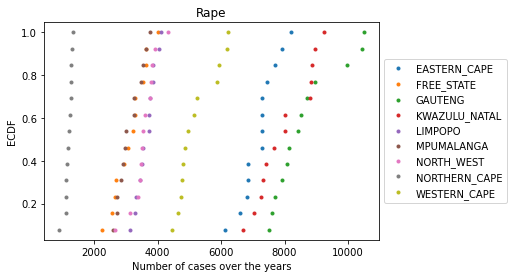

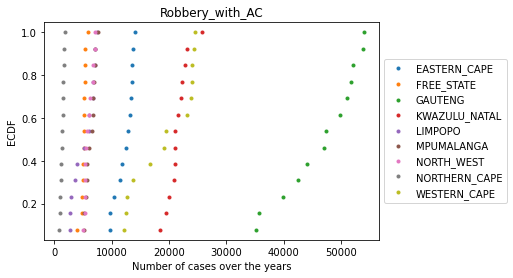

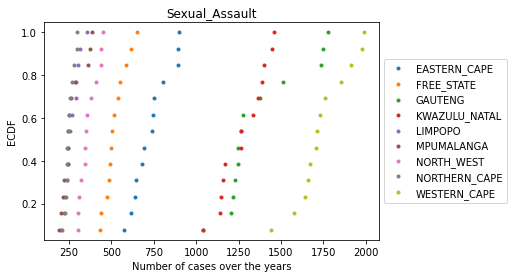

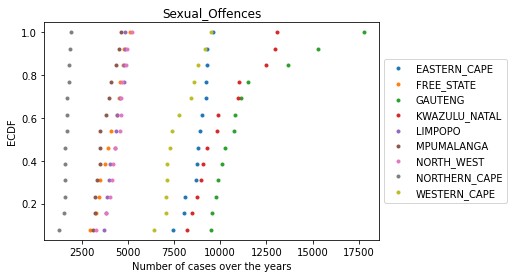

In [96]:
for title in list(grouped_by_province['Crime Category'].unique()):
    generate_ECDF(title)

## EDA - Distribution by Cluster

Next we will get a visual understanding of the contact crime distribution per category by cluster.

In [97]:
# group the data by crime category and province
grouped_by_cluster = contact_crime_df.groupby(['Crime Category', 'cluster'])[list_of_years].sum()

# reset the index and extrapolate the index into column
grouped_by_cluster = grouped_by_cluster.reset_index()
grouped_by_cluster.head()

,Crime Category,cluster,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021
0,Assault_GBH,ALICE CC,1335.0,1366.0,1313.0,1322.0,1225.0,1279.0,1179.0,1206.0,1121.0,1119.0,1176.0,1158.0,887.0
1,Assault_GBH,ALIWAL NORTH CC,1245.0,1306.0,1271.0,1282.0,1212.0,1284.0,1266.0,1249.0,1298.0,1219.0,1158.0,1135.0,975.0
2,Assault_GBH,AMAJUBA CC,1387.0,1514.0,1487.0,1600.0,1519.0,1724.0,1886.0,1957.0,1837.0,1718.0,1664.0,1665.0,1462.0
3,Assault_GBH,BOJANALA DISTRICT,5610.0,5615.0,5479.0,5368.0,5158.0,4731.0,4913.0,4944.0,4581.0,4778.0,4871.0,4428.0,3941.0
4,Assault_GBH,BUTTERWORTH CC,1332.0,1471.0,1461.0,1497.0,1458.0,1537.0,1565.0,1614.0,1473.0,1312.0,1452.0,1322.0,1194.0


In [98]:
contact_crime_df[contact_crime_df['station'] == 'LAERSDRIFT']['cluster'].unique()

array(['NKANGALA DISTRICT', nan], dtype=object)

In order to eliminate the nan values we will fill the nan `cluster` for the `LAERSDRIFT` station with `NKANGALA DISTRICT`.

In [99]:
# replace the null cluster values for Laersdrift
contact_crime_df.loc[contact_crime_df['cluster'].isnull(), 'cluster'] = 'NKANGALA DISTRICT'

In [100]:
# add ISO codes to identify county and provinces
contact_crime_df['ISO code'] = 'ZAF-'+ contact_crime_df['prov']

In [101]:
contact_crime_df['ISO code'].unique()


array(['ZAF-EC', 'ZAF-FS', 'ZAF-GP', 'ZAF-KZN', 'ZAF-LP', 'ZAF-MP',
       'ZAF-NW', 'ZAF-NC', 'ZAF-WC'], dtype=object)

In [102]:
# export the contact_crime_df
contact_crime_df.to_csv('contact_crime_df.csv', index = False)

## EDA - Distribution by Station

Next we will get a visual understanding of the contact crime distribution per category by station.

In [112]:
contact_crime_df.tail()

,station,Station_type,Province_station,cluster,prov,Crime Category,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021,ISO code
45588,LAERSDRIFT,0,LIMPOPO,NKANGALA DISTRICT,LP,Murder,0.0,1.0,1.0,0.0,2.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,ZAF-LP
45591,LAERSDRIFT,0,LIMPOPO,NKANGALA DISTRICT,LP,Rape,7.0,5.0,1.0,8.0,1.0,1.0,0.0,3.0,4.0,1.0,0.0,0.0,0.0,ZAF-LP
45595,LAERSDRIFT,0,LIMPOPO,NKANGALA DISTRICT,LP,Robbery_with_AC,4.0,3.0,3.0,3.0,5.0,7.0,7.0,16.0,10.0,9.0,0.0,0.0,0.0,ZAF-LP
45596,LAERSDRIFT,0,LIMPOPO,NKANGALA DISTRICT,LP,Sexual_Assault,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ZAF-LP
45597,LAERSDRIFT,0,LIMPOPO,NKANGALA DISTRICT,LP,Sexual_Offences,10.0,5.0,2.0,9.0,1.0,1.0,0.0,4.0,5.0,3.0,0.0,0.0,0.0,ZAF-LP


Next we will get the geo location coordinates for each city.

In [139]:
# group the data by crime category and province
grouped_by_station = contact_crime_df.groupby(['Province_station','station','Crime Category'])[list_of_years].sum()

# reset the index and extrapolate the index into column
grouped_by_station = grouped_by_station.reset_index()

# replace the _ with a space for provinces
grouped_by_station['Province_station'] = grouped_by_station['Province_station'].str.replace('_',' ')

# change the case of the names
grouped_by_station['Province_station'] = grouped_by_station['Province_station'].str.title()
grouped_by_station['station'] = grouped_by_station['station'].str.title()

# create a loation reference
grouped_by_station['location_reference'] = ('South Africa, ' + 
                                            grouped_by_station['Province_station'] +
                                            ', '+ grouped_by_station['station'])


In [492]:
# extract the logitude and latitude into lists
places = grouped_by_station.location_reference.unique()
longitude = []
latitude = []
for p in places:
    information = geocode(p, provider= 'nominatim', user_agent = 'xyz', timeout=5)
    if information.address[0] != None:
        longitude.append(information.geometry.x[0])
        latitude.append(information.geometry.y[0])
    else:
        longitude.append(0)
        latitude.append(0) 

In [493]:
# create a data frame with the coordinates
places_df = pd.DataFrame(
    {'places': places,
     'longitude': logitude,
     'latitude': latitude
    })

In [548]:
places_df.head()

,places,longitude,latitude
0,"South Africa, Eastern Cape, Aberdeen",24.065445,-32.476416
1,"South Africa, Eastern Cape, Addo",25.712484,-33.522092
2,"South Africa, Eastern Cape, Adelaide",26.295050,-32.706019
3,"South Africa, Eastern Cape, Afsondering",0.000000,0.000000
4,"South Africa, Eastern Cape, Alexandria",26.409444,-33.653056


In [591]:
# import from external correction
unknown_places = pd.read_csv('unknown_places.csv')
unknown_places.head()

,places,longitude,latitude
0,"South Africa, Eastern Cape, Afsondering",28.96145,-30.16502
1,"South Africa, Eastern Cape, Algoapark",25.57071,-33.90246
2,"South Africa, Eastern Cape, Bholothwa",27.19920,-31.98620
3,"South Africa, Eastern Cape, Bridge Camp",0.00000,0.00000
4,"South Africa, Eastern Cape, Committees",0.00000,0.00000


In [592]:
# isolate the place names
unknown_places['place_name'] = unknown_places['places'].str.split(',').str[2].str.strip()
unknown_places

,places,longitude,latitude,place_name
0,"South Africa, Eastern Cape, Afsondering",28.96145,-30.16502,Afsondering
1,"South Africa, Eastern Cape, Algoapark",25.57071,-33.90246,Algoapark
2,"South Africa, Eastern Cape, Bholothwa",27.19920,-31.98620,Bholothwa
3,"South Africa, Eastern Cape, Bridge Camp",0.00000,0.00000,Bridge Camp
4,"South Africa, Eastern Cape, Committees",0.00000,0.00000,Committees
...,...,...,...,...
123,"South Africa, Western Cape, Gans Bay",0.00000,0.00000,Gans Bay
124,"South Africa, Western Cape, Int Airport C Town",18.59638,-33.96441,Int Airport C Town
125,"South Africa, Western Cape, Lingelethu-West",18.66004,-34.04298,Lingelethu-West
126,"South Africa, Western Cape, Riebeek West",0.00000,0.00000,Riebeek West


In [367]:
# list of places with no latitude and longitude
saps_search_list = list(unknown_places[unknown_places['longitude'] == 0].place_name)

Next I will scrape the SAPS website for the missing latitude and longitude information. First I connect to the SAPS website. A status code of 200 means the request was successful. I make use of regular expressions to retrieve the location ID; `sid` for each station.

In [343]:
browser = mechanicalsoup.Browser()

In [484]:
id_list = []
for place in saps_search_list:
    sapsurl = 'https://www.saps.gov.za/contacts/stationlist.php?stationsearch='+ place
    
    # open the url
    sapspage = browser.get(sapsurl)

    if sapspage.status_code == 200 and len(sapspage.soup.findAll('ul')) < 7:
        # inspect the page
        sapspage.soup

        # retrieve the location identification number
        section = sapspage.soup.findAll('ul')[-1]
        text = str(section)
        id = re.findall(r'sid=\d*', text)[0].split('=')[1]

        # save the id number in a list
        id_list.append(id)
    else:
        id_list.append('error')


In [490]:
# print the list station IDs
print(id_list)

['897', '1185', '1211', '859', '904', '949', '889', '838', '909', '862', '952', '1516', '892', '806', '956', '959', '1272', '842', '1697', '870', '832', '965', '844', '967', '938', '1186', '818', '846', '569', '578', '512', '515', '598', '1077', '555', '236', '457', '1239', '1294', 'error', '450', 'error', '1298', '1299', '213', '671', '1090', '661', '1146', '1121', '696', '948', '950', '1200', '642', '1161', '1287', '1168', '1178', '690', '1275', '710', '712', '1716', '714', '715', '718', '781', '765', '766', '1416', '769', '1436', '1417', '752', '729', '753', '731', '789', '790', '1210', '734', '1457', '736', '791', '1202', '1034', '741', '990', '1020', '1061', '996', '1203', '1219', '380', '382', '412', 'error', '268', '279', '286', '295', '323', '325', '299', '1270', '41', '44', 'error', '179']


In [489]:
lat = []
long = []

for id in id_list:
    sapsurl = 'https://www.saps.gov.za/contacts/stationdetails.php?sid='+id
    
    if id != 'error':

        # open the url
        sapspage = browser.get(sapsurl)
        #sapspage

        # inspect the page
        sapspage.soup

        # convert the html to text
        text = str(sapspage.soup)

        # retrieve the latitude and longitude numbers
        lat.append(float(str(re.findall(r"LATITUDE:</b>\s[-+]?\d*\.\d+", text)[0]).split(' ')[1]))
        long.append(float(str(re.findall(r"LONGITUDE:</b>\s[-+]?\d*\.\d+", text)[0]).split(' ')[1]))
        
    else:
        lat.append('error')
        long.append('error')

print(lat)
print(long)



[-32.02197, -33.16014, -30.80423, -32.74839, -32.3144, -31.26654, -33.93989, -32.56819, -32.16655, -32.42247, -31.9192, -31.05498, -33.87626, -30.64249, -31.14658, -31.20766, -30.57749, -33.06903, -29.69876, -33.44057, -32.72903, -31.01688, -32.97844, -31.22086, -31.98433, -33.12668, -30.59053, -32.77056, -29.25967, -30.5913, -29.32488, -28.53211, -29.49944, -28.62038, -26.92008, -26.34619, -26.12412, -25.71357, -26.24153, 'error', -26.47848, 'error', -26.76453, -26.87308002, -25.82374, -28.94127, -28.4618, -29.14101, -30.03691, -27.99895, -27.97561, -30.34742, -30.40506, -30.13768, -29.94046, -30.49365, -28.55147, -30.52934, -29.68305, -28.81018, -23.49214, -24.12651, -24.06064, -24.6022896, -24.71591, -23.48766, -24.45995, -22.65248, -22.89844, -24.23447, -24.985436, -24.38627, -23.52211, -24.89172, -23.88811, -22.56206, -22.83111, -24.03597, -22.38491, -22.80382, -23.35999, -24.90246, -22.95847, -23.52831, -23.12982, -23.33168, -25.16611, -24.98705, -26.18032, -25.36766, -24.99079, 

Next I will create a dataframe of the place names, latitude and longitude.

In [593]:
unknown_filled = pd.DataFrame({'places': saps_search_list,
     'longitude': long,
     'latitude': lat
    })

unknown_filled

,places,longitude,latitude
0,Bridge Camp,27.3588,-32.02197
1,Committees,26.83654,-33.16014
2,Elands Height,28.22494,-30.80423
3,Healdtown,26.64999,-32.74839
4,Henderson,27.33609,-32.3144
...,...,...,...
105,Da Gamaskop,22.11733,-34.17631
106,Elands Bay,18.34069,-32.31333
107,Gans Bay,19.35139,-34.57818
108,Riebeek West,error,error


In [594]:
# print the errors
unknown_filled[unknown_filled['longitude'] == 'error']

,places,longitude,latitude
39,Norkempark,error,error
41,Sophia Town,error,error
97,Pampierstat,error,error
108,Riebeek West,error,error


The above four station require manual correction as the names were misspelled. These will be directly edited onto `unknown_places` and will be filtered out of `unknown_filled`

In [595]:
# correct the misspelling and insert latitude and longitude
corrections = {'Norkempark':['Norkem Park', {'latitude': -26.05456, 'longitude': 28.22334}],
                    'Sophia Town':['Sophiatown', {'latitude': -26.17733, 'longitude': 27.97173}],
                    'Pampierstat':['Pampierstad', {'latitude': -27.77091, 'longitude': 24.69018}],
                    'Riebeek West':['Riebeek-West', {'latitude': -33.35093, 'longitude': 18.8727}]
                   }

# make corrections
for k,v in corrections.items():
    unknown_places.loc[unknown_places.place_name == k, 'latitude'] = v[1]['latitude']
    unknown_places.loc[unknown_places.place_name == k, 'longitude'] = v[1]['longitude']
#     unknown_places.loc[unknown_places.place_name == k, 'place_name'] = v[0]
    

Next I will merge the filled data back into the main dataframe

In [596]:
# exclude the errors
unknown_filled = unknown_filled[unknown_filled['longitude'] != 'error']

In [597]:
unknown_filled.head()

,places,longitude,latitude
0,Bridge Camp,27.3588,-32.02197
1,Committees,26.83654,-33.16014
2,Elands Height,28.22494,-30.80423
3,Healdtown,26.64999,-32.74839
4,Henderson,27.33609,-32.3144


Next I will merge the `unknown_places` with `unknown_filled` dataframe.

In [598]:
# merge the known with the unknown
places_all_known = pd.merge(left=unknown_places, right=unknown_filled, 
                            how='outer', left_on='place_name', right_on='places')


In [599]:
# replace the null latitude and longitude values
places_all_known.loc[places_all_known['longitude_x'] == 0, 'longitude_x'] = places_all_known['longitude_y']
places_all_known.loc[places_all_known['latitude_x'] == 0, 'latitude_x'] = places_all_known['latitude_y']

# drop redundant columns
places_all_known.drop(['places_x','places_y','longitude_y','latitude_y'], axis=1, inplace=True)
places_all_known

,longitude_x,latitude_x,place_name
0,28.96145,-30.16502,Afsondering
1,25.57071,-33.90246,Algoapark
2,27.1992,-31.9862,Bholothwa
3,27.3588,-32.02197,Bridge Camp
4,26.83654,-33.16014,Committees
...,...,...,...
123,19.35139,-34.57818,Gans Bay
124,18.59638,-33.96441,Int Airport C Town
125,18.66004,-34.04298,Lingelethu-West
126,18.8727,-33.35093,Riebeek West


Next I will merge the coordinates into the `contact_crime` dataframe from `places_all_known` and `places_df`.

In [601]:
# merge contact crime with places_all_known 
contact_crime_geo = pd.merge(left=contact_crime_df, right=places_all_known,
                            how='left', left_on=contact_crime_df['station'].str.title(),
                            right_on='place_name')

contact_crime_geo.head()

,station,Station_type,Province_station,cluster,prov,Crime Category,2008-2009,2009-2010,2010-2011,2011-2012,...,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2021,ISO code,longitude_x,latitude_x,place_name
0,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Assault_GBH,69.0,67.0,53.0,62.0,...,87.0,61.0,58.0,54.0,60.0,48.0,ZAF-EC,NaN,NaN,Aberdeen
1,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Attempted_murder,0.0,3.0,0.0,0.0,...,5.0,2.0,1.0,2.0,4.0,2.0,ZAF-EC,NaN,NaN,Aberdeen
2,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Attempted_sexual_offences,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,ZAF-EC,NaN,NaN,Aberdeen
3,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Common_assault,32.0,31.0,24.0,19.0,...,48.0,24.0,24.0,32.0,28.0,34.0,ZAF-EC,NaN,NaN,Aberdeen
4,ABERDEEN,ABERDEEN,EASTERN_CAPE,GRAAFF-REINET CC,EC,Common_robbery,3.0,2.0,5.0,1.0,...,10.0,10.0,6.0,7.0,1.0,7.0,ZAF-EC,NaN,NaN,Aberdeen


In [602]:
# filter out the already assigned coordinates in the existing dataframe
placed_nominatim = places_df[places_df['longitude'] != 0]

# extract place name into a separate column
placed_nominatim['place_name'] = placed_nominatim['places'].str.split(',').str[-1].str.strip()

placed_nominatim.head()

,places,longitude,latitude,place_name
0,"South Africa, Eastern Cape, Aberdeen",24.065445,-32.476416,Aberdeen
1,"South Africa, Eastern Cape, Addo",25.712484,-33.522092,Addo
2,"South Africa, Eastern Cape, Adelaide",26.295050,-32.706019,Adelaide
4,"South Africa, Eastern Cape, Alexandria",26.409444,-33.653056,Alexandria
6,"South Africa, Eastern Cape, Alice",26.834444,-32.788889,Alice


In [603]:
# merge contact_crime_geo with placed_nominatim
contact_crime_geo = pd.merge(left=contact_crime_geo, right=placed_nominatim,
                            how='left', left_on='place_name',
                            right_on='place_name')

In [607]:
# clean up the contact_crime_geo latitude and longitude values
contact_crime_geo.loc[contact_crime_geo['longitude'].isnull(), 'longitude'] = contact_crime_geo['longitude_x']
contact_crime_geo.loc[contact_crime_geo['latitude'].isnull(), 'latitude'] = contact_crime_geo['latitude_x']

print(contact_crime_geo[contact_crime_geo['longitude'].isnull()])
print(contact_crime_geo[contact_crime_geo['latitude'].isnull()])

Empty DataFrame
Columns: [station, Station_type, Province_station, cluster, prov, Crime Category, 2008-2009, 2009-2010, 2010-2011, 2011-2012, 2012-2013, 2013-2014, 2014-2015, 2015-2016, 2016-2017, 2017-2018, 2018-2019, 2019-2020, 2020-2021, ISO code, longitude_x, latitude_x, place_name, places, longitude, latitude]
Index: []

[0 rows x 26 columns]
Empty DataFrame
Columns: [station, Station_type, Province_station, cluster, prov, Crime Category, 2008-2009, 2009-2010, 2010-2011, 2011-2012, 2012-2013, 2013-2014, 2014-2015, 2015-2016, 2016-2017, 2017-2018, 2018-2019, 2019-2020, 2020-2021, ISO code, longitude_x, latitude_x, place_name, places, longitude, latitude]
Index: []

[0 rows x 26 columns]


In [608]:
# drop redundant columns
contact_crime_geo.drop(['longitude_x','latitude_x','place_name','places'], axis=1, inplace=True)

**Machine Learning Checkpoint**

Import `contact_crime_geo.to_csv`

In [7]:
# import contact_crime_geo
contact_crime_geo = pd.read_csv('contact_crime_geo.csv')

# error correction due to human error on SAPS website
contact_crime_geo.loc[contact_crime_geo['station'] == 'DRIEKOP', 'longitude'] = contact_crime_geo['longitude'] * -1
contact_crime_geo.loc[contact_crime_geo['station'] == 'QHASA', 'longitude'] = contact_crime_geo['longitude'] * -1

In [9]:
# export the contact_crime_df
contact_crime_geo.to_csv('contact_crime_geo.csv', index = False)

# Dataframe Engineering
Next we will transpose the data so that we are left with two data frames:
* One will have the years as features where I will attempt to predict 2020-2021 - This table already exists as `grouped_by_station`
* One will have the crimes as features and the target will be the number of Murder cases for the year 2020-2021

In [105]:
# subset the data
grouped_by_station_2021 = grouped_by_station[['Crime Category','station', '2020-2021']]
# pivot the data
grouped_by_station_21_pivot = grouped_by_station_2021.pivot_table(index='station',
                                                                  values='2020-2021', 
                                                                  columns='Crime Category')
# reset the index of the pivoted data
grouped_by_station_21_pivot = grouped_by_station_21_pivot.reset_index()
# rename the index of the pivoted data
grouped_by_station_21_pivot.index.names = ['index']
# print first 5 rows
grouped_by_station_21_pivot.head()

Crime Category,station,Assault_GBH,Attempted_murder,Attempted_sexual_offences,Common_assault,Common_robbery,Contact_sexual_offences,Murder,Rape,Robbery_with_AC,Sexual_Assault,Sexual_Offences
index,,,,,,,,,,,,
0,ABERDEEN,48.0,2.0,1.0,34.0,7.0,1.0,4.0,6.0,5.0,4.0,12.0
1,ACORNHOEK,283.0,42.0,3.0,178.0,39.0,0.0,33.0,84.0,244.0,4.0,91.0
2,ACTONVILLE,150.0,23.0,2.0,94.0,24.0,0.0,33.0,19.0,102.0,3.0,24.0
3,ADDO,140.0,19.0,0.0,64.0,10.0,1.0,21.0,41.0,50.0,4.0,46.0
4,ADELAIDE,44.0,11.0,1.0,24.0,8.0,0.0,5.0,9.0,15.0,4.0,14.0


Next we will determine the Pearson correlation coefficient for all crimes as it relates to Murder as well as draw a scatterplot of the crime categories in question. Below is a function to calculate the Pearson correlation coefficient and the draw the scatterplot.

In [106]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)
    
    return corr_mat[0,1]

In [107]:
# make a deep copy of the c_list
scat_list = copy.deepcopy(c_list)
# remove the Murder category
scat_list.remove('Murder')

Murder and Assault_GBH for 2021 
Pearson correlation coefficient: : 0.675280629881866
LinregressResult(slope=0.13721898695862647, intercept=0.2554039749928094, rvalue=0.6752806298818661, pvalue=5.1854643587562465e-155, stderr=0.004408074043215851, intercept_stderr=0.8098273542278439)


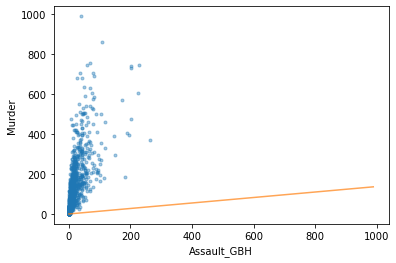

Murder and Attempted_murder for 2021 
Pearson correlation coefficient: : 0.8529780836560044
LinregressResult(slope=0.8845460599038014, intercept=2.957510239533322, rvalue=0.8529780836560046, pvalue=0.0, stderr=0.015919515408843447, intercept_stderr=0.4953368586422046)


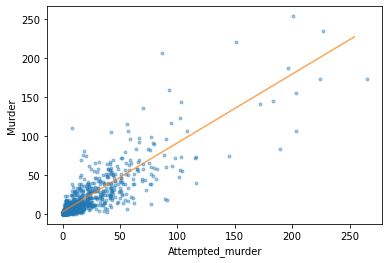

Murder and Attempted_sexual_offences for 2021 
Pearson correlation coefficient: : 0.43610202632036993
LinregressResult(slope=5.441662956591187, intercept=8.788434091654459, rvalue=0.43610202632037, pvalue=5.973181749811765e-55, stderr=0.3302611828175493, intercept_stderr=0.8923482453713671)


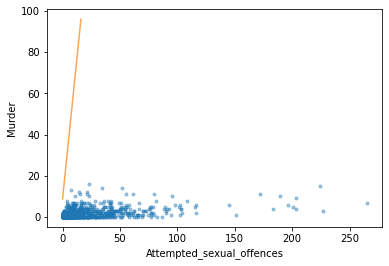

Murder and Common_assault for 2021 
Pearson correlation coefficient: : 0.6552328975236151
LinregressResult(slope=0.10584252521148538, intercept=3.5878077265502615, rvalue=0.6552328975236152, pvalue=5.5457841200334025e-143, stderr=0.0035890379106908745, intercept_stderr=0.7680826147180875)


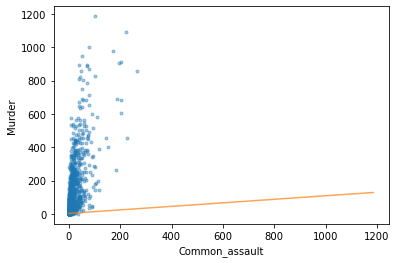

Murder and Common_robbery for 2021 
Pearson correlation coefficient: : 0.4339711165393863
LinregressResult(slope=0.20598452821658056, intercept=10.550167946202224, rvalue=0.43397111653938625, pvalue=2.250945249174557e-54, stderr=0.012577211293133172, intercept_stderr=0.8373571200391361)


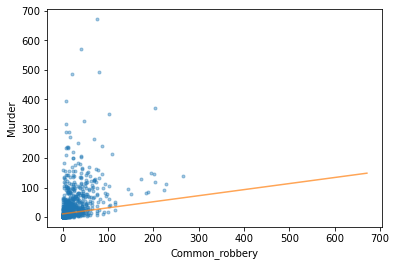

Murder and Contact_sexual_offences for 2021 
Pearson correlation coefficient: : 0.344251506165328
LinregressResult(slope=6.654873502538974, intercept=11.161044007609004, rvalue=0.344251506165328, pvalue=1.4677527113760757e-33, stderr=0.5338189114727218, intercept_stderr=0.9045560870684471)


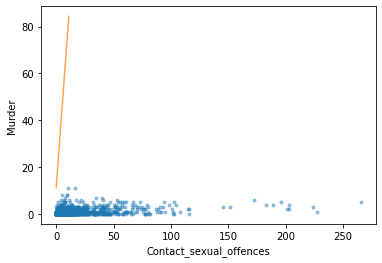

Murder and Rape for 2021 
Pearson correlation coefficient: : 0.7853958319718786
LinregressResult(slope=0.6179581611039285, intercept=-2.1402590612311947, rvalue=0.7853958319718786, pvalue=4.6179448347637287e-243, stderr=0.014324448075598661, intercept_stderr=0.6738133683296514)


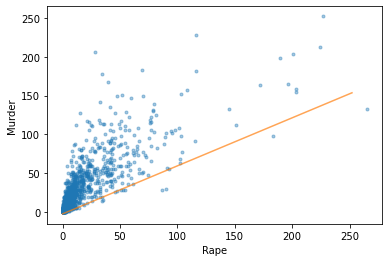

Murder and Robbery_with_AC for 2021 
Pearson correlation coefficient: : 0.7178633234109791
LinregressResult(slope=0.12096243635133541, intercept=4.7286188818822215, rvalue=0.7178633234109791, pvalue=5.046686877131767e-184, stderr=0.0034502766590381356, intercept_stderr=0.6680909717137633)


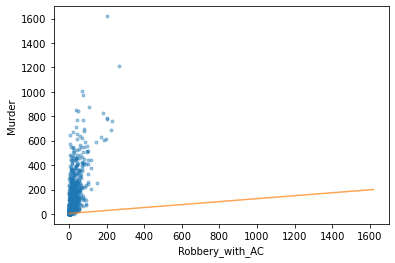

Murder and Sexual_Assault for 2021 
Pearson correlation coefficient: : 0.6596491760351058
LinregressResult(slope=2.564392685072507, intercept=1.6901048250135062, rvalue=0.6596491760351059, pvalue=1.491698594647529e-145, stderr=0.08593382409839391, intercept_stderr=0.8021060046738322)


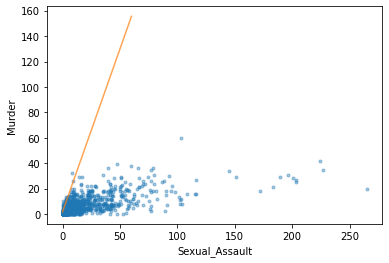

Murder and Sexual_Offences for 2021 
Pearson correlation coefficient: : 0.7963592786108125
LinregressResult(slope=0.5195524152102972, intercept=-3.48756072239091, rvalue=0.7963592786108125, pvalue=1.0766311095754886e-254, stderr=0.011605672756866543, intercept_stderr=0.6746670482321389)


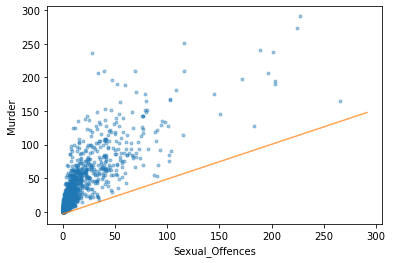

In [108]:
# empty dictionary for correlations
correlation_dict = {'crimes':[],'coefficient':[]}

for crime in scat_list:
    
    # Compute Pearson correlation coefficient for I. versicolor: r
    r = pearson_r(grouped_by_station_21_pivot[crime], grouped_by_station_21_pivot['Murder'])

    # Print the result
    print('Murder and',crime,'for 2021','\nPearson correlation coefficient:',':',r)
    
    # Make a scatter plot
    _ = plt.plot(grouped_by_station_21_pivot['Murder'],
                 grouped_by_station_21_pivot[crime], 
                 marker='.', linestyle='none', alpha=0.4) # , markersize=7
    
#     # reduce to upper and lower bounds of the data
#     _ = plt.axis([np.min(grouped_by_station_21_pivot[crime]),
#                  np.max(grouped_by_station_21_pivot[crime]),
#                  np.min(grouped_by_station_21_pivot['Murder']),
#                  np.max(grouped_by_station_21_pivot['Murder'])])

    # produce a line of best fit: subset the data
    subset = grouped_by_station_21_pivot.dropna(subset=[crime, 'Murder'])
    xs = subset[crime]
    ys = subset['Murder']
    
    # comput the linear regression
    res = linregress(xs, ys) 
    print(res)
    
    # plot the line
    fx = np.array([xs.min(), xs.max()])
    fy = res.intercept + res.slope * fx
    _ = plt.plot(fx, fy, '-', alpha=0.7)

    # Label the axes
    _ = plt.xlabel(crime)
    _ = plt.ylabel('Murder')

    # Show the result
    plt.show()

    
    # fill the correlation dict with the Pearson correlation coefficients
    correlation_dict['crimes'].append('Murder to '+ str(crime))
    correlation_dict['coefficient'].append(r)
      

In [109]:
# convert the correlation dict into a DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_dict)

# sort the correlation DataFrame
correlation_df.sort_values(by='coefficient', 
                           ascending=False,
                          inplace=True)

# print the correlation dataframe 
print(correlation_df)



                                crimes  coefficient
1           Murder to Attempted_murder     0.852978
9            Murder to Sexual_Offences     0.796359
6                       Murder to Rape     0.785396
7            Murder to Robbery_with_AC     0.717863
0                Murder to Assault_GBH     0.675281
8             Murder to Sexual_Assault     0.659649
3             Murder to Common_assault     0.655233
2  Murder to Attempted_sexual_offences     0.436102
4             Murder to Common_robbery     0.433971
5    Murder to Contact_sexual_offences     0.344252


In [110]:
# subset the dataframe to only crime categories
subset = grouped_by_station_21_pivot[c_list]
# depict a correlation matrix between the features
subset.corr()

Crime Category,Assault_GBH,Attempted_murder,Attempted_sexual_offences,Common_assault,Common_robbery,Contact_sexual_offences,Murder,Rape,Robbery_with_AC,Sexual_Assault,Sexual_Offences
Crime Category,,,,,,,,,,,
Assault_GBH,1.000000,0.664905,0.548966,0.800260,0.553149,0.369372,0.675281,0.857589,0.689037,0.715757,0.872386
Attempted_murder,0.664905,1.000000,0.379308,0.729483,0.527302,0.385079,0.852978,0.707990,0.740499,0.721509,0.740965
Attempted_sexual_offences,0.548966,0.379308,1.000000,0.433222,0.290924,0.297707,0.436102,0.564838,0.351139,0.375239,0.593659
Common_assault,0.800260,0.729483,0.433222,1.000000,0.721069,0.498866,0.655233,0.711505,0.784323,0.831580,0.769012
Common_robbery,0.553149,0.527302,0.290924,0.721069,1.000000,0.420058,0.433971,0.496066,0.783990,0.652287,0.550185
Contact_sexual_offences,0.369372,0.385079,0.297707,0.498866,0.420058,1.000000,0.344252,0.374102,0.415605,0.493976,0.442413
Murder,0.675281,0.852978,0.436102,0.655233,0.433971,0.344252,1.000000,0.785396,0.717863,0.659649,0.796359
Rape,0.857589,0.707990,0.564838,0.711505,0.496066,0.374102,0.785396,1.000000,0.710192,0.708835,0.990298
Robbery_with_AC,0.689037,0.740499,0.351139,0.784323,0.783990,0.415605,0.717863,0.710192,1.000000,0.728447,0.743514
